### Sweeping poisson ratios


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import saxophone.simulation as simulation
import saxophone.utils as utils

In [2]:
def extract_data(path):
    folder_list = [folder for folder in os.listdir(path) if os.path.isdir(os.path.join(path, folder))]
    results = []
    for folder_name in folder_list:
        full_folder_path = os.path.join(path, folder_name)
        file_list = os.listdir(full_folder_path)
        for file_name in file_list:
            if file_name.endswith('.npz'):
                with np.load(os.path.join(full_folder_path, file_name), allow_pickle=True) as file:
                    file_data = {key: file[key] if file[key].size > 1 else file[key].item() for key in file.files}
                    file_data['folder_name'] = folder_name  # Attach folder name to the results
                    file_data['file_name'] = file_name
                    results.append(file_data)
    return results

In [3]:
def plot_results(results, x_key, y_key, color_key=None, x_limits=(-1, 1), y_limits=(0, 1), cmap='jet', vmin=0, vmax=1):
    if not results:
        print("No data to plot.")
        return

    try:
        # Extracting data using dynamic keys
        x_data = [data[x_key] for data in results if x_key in data]
        y_data = [data[y_key] for data in results if y_key in data]
        color_data = [data[color_key] for data in results if color_key in data]

        # Check if data lengths match
        if len(x_data) != len(y_data):
            raise ValueError("Data lengths do not match.")

        # Plotting the data
        plt.scatter(x_data, y_data, c=color_data, marker='o', cmap=cmap, vmin=vmin, vmax=vmax)
        plt.xlim(x_limits)  # Setting x-axis limits
        plt.ylim(y_limits)
        plt.xlabel(x_key)  # X-axis label
        plt.ylabel(y_key)  # Y-axis label
        colorbar = plt.colorbar()  # Colorbar
        colorbar.set_label(color_key)  # Colorbar label
        plt.title(f'{y_key} vs {x_key}')  # Plot title
        plt.show()
    except KeyError as e:
        print(f"Error: Missing key {str(e)} - Check the keys in your datasets.")
    except ValueError as e:
        print(f"Error: {str(e)}")
    except Exception as e:
        print(f"Unexpected error: {str(e)} - Check data types and array shapes.")

In [4]:
def rerun(results, run_nr):
    R_key = 'R_temp'
    R_temp = [data[R_key] for data in results if R_key in data]
    k_key = 'k_temp'
    k_temp = [data[k_key] for data in results if k_key in data]

    perturbation = 2.0
    delta_perturbation = 0.1
    steps = 50
    write_every = 1
    size = 10
    system = utils.System(size, 26+run_nr, 2.0, 0.2, 1e-1)
    system.initialize()
    system.auxetic_parameters(perturbation, delta_perturbation, steps, write_every)
    displacement = system.displacement
    shift = system.shift

    poisson, log, R_init, R_final = simulation.simulate_auxetic_NOMM(R_temp[0], k_temp[0], system, shift, displacement)

    return poisson, log

In [5]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'sweep_poisson')
results = extract_data(folder_path)

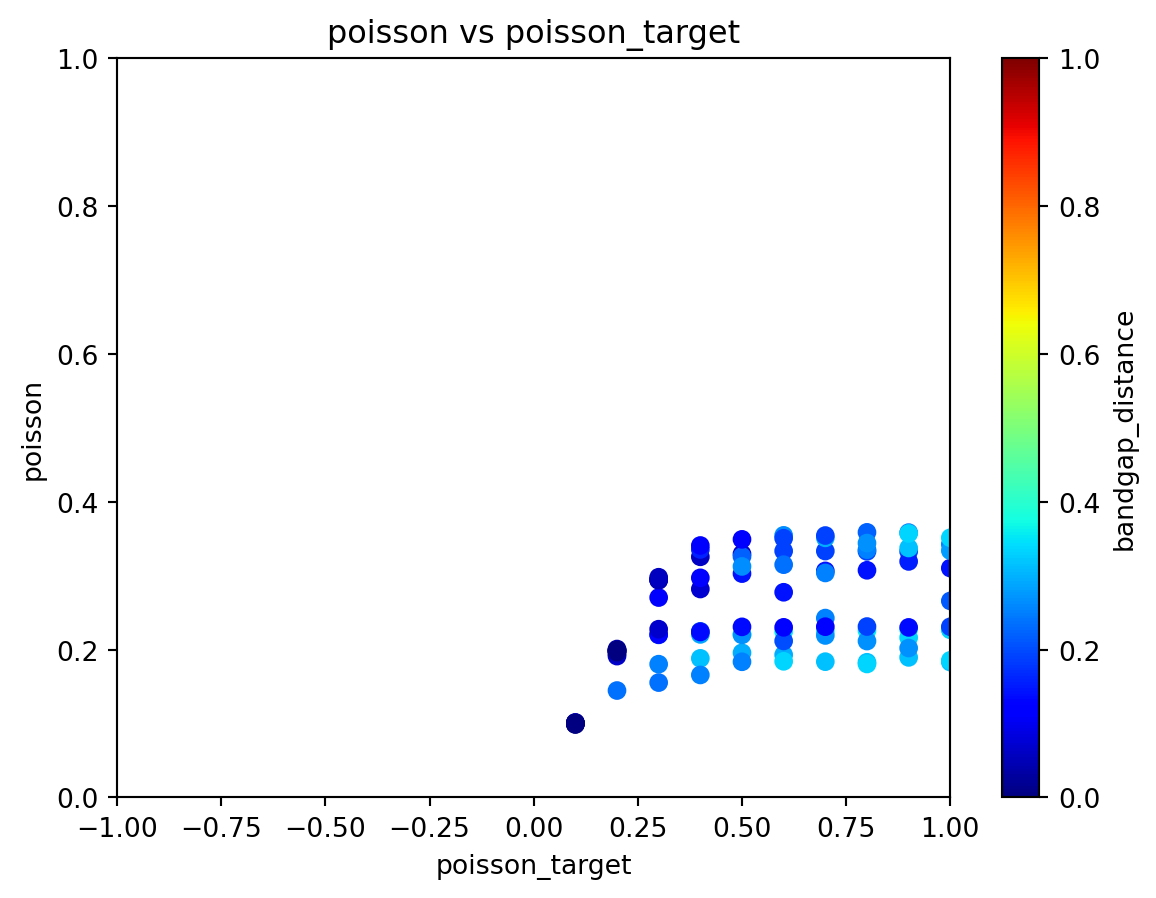

In [6]:
#| label: fig-poissonratios
#| fig-cap: Poisson ratio achieved vs target. Color bar represents bandgap difference.
plot_results(results, 'poisson_target', 'poisson', 'bandgap_distance')

::: {.notes}
As we can see from @fig-poissonratios, beyond a poisson ratio target of $\pm 0.3$, we are not able to achieve it, and the curve flattens out. Interestingly, the color suggests that achieving a larger bandgap at negative poisson ratios is harder than at positive ratios. The next steps are to see if we can achieve better poisson ratios by decreasing the sphere size. 
:::

### Decreasing sphere radius

::: {.notes}
To decrease the sphere radius, I modified this part of the code:


```{.python include="saxophone/simulation.py" start-line=271 end-line=277 filename="saxophone/simulation.py" code-line-numbers="true"}
```
In line 275 I change the sigma.
:::


In [7]:
folder_path = os.path.join(os.getcwd(), 'runs', 'decrease_sphere')
results = extract_data(folder_path)

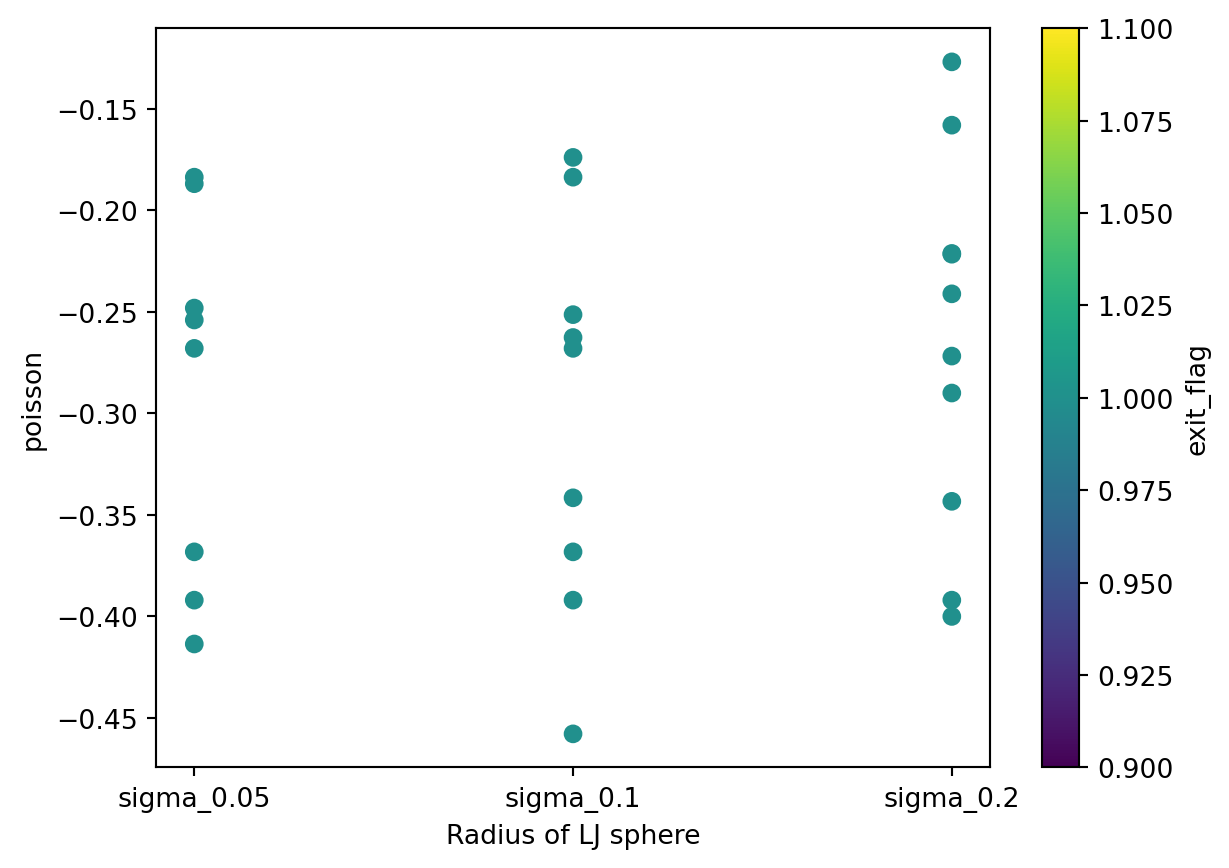

In [8]:
#| label: fig-sphere-poisson
#| fig-cap: Poisson ratio achieved vs target for LJ radius of 0.2.
x_key = 'folder_name'
y_key = 'poisson'
color_key = 'exit_flag'
x_data = [data[x_key] for data in results if x_key in data]
y_data = [data[y_key] for data in results if y_key in data]
color_data = [data[color_key] for data in results if color_key in data]
plt.scatter(x_data, y_data, c=color_data, marker='o')
plt.xlabel('Radius of LJ sphere')  # X-axis label
plt.ylabel(y_key)  # Y-axis label
colorbar = plt.colorbar()  # Colorbar
colorbar.set_label(color_key)  # Colorbar label
plt.show()

::: {.notes}
::: {.callout-note collapse="true"}
## These are comments from an older run
*When I first ran these, I ran only for $\sigma = 0.2$ and tried to use different target poisson ratios, but the run I used doesn't use target poisson, it just tries to minimize poisson ratio.*

This did not work as expected. Each run is identical to each other, because poisson target is not an input to the `generate_auxetic()` function, as it just tries to minimize the poisson ratio. What is interesting tho is that all of the 4 runs are identical. Should they be? Yes, because the random seed is fixed as 26+run, 

```{.python include="saxophone/simulation.py" start-line=889 end-line=900 filename="saxophone/simulation.py" code-line-numbers="true"}
```
so since each run is 0-9 they have a different random seed, but all the runs in different poisson ratio folders will be identical for the same number 0-9, so it makes sense. However, it is still useful in the sense that we're still not getting very negative poisson ratios, max is around $-0.4$
:::

Also as seen in @fig-sphere-poisson, for the points labeled sigma_0.1, there is a shift towards more negative poisson ratios but still not very significant. Another challenge is that the variance for different runs is very large. Also for $\sigma = 0.1$, not all the runs completed since it ran out of memory. How can the code be made less memory-intensive? Also, none of the runs are converging, they all have exit-flag 1, which is that gradients are exceeded. Is that because the sphere radius is too small? 
:::


In [9]:
#| eval: false
poisson, log = rerun(results, 6)

In [10]:
folder_path = os.path.join(os.getcwd(), 'runs', 'k_angle_decrease')
results = extract_data(folder_path)

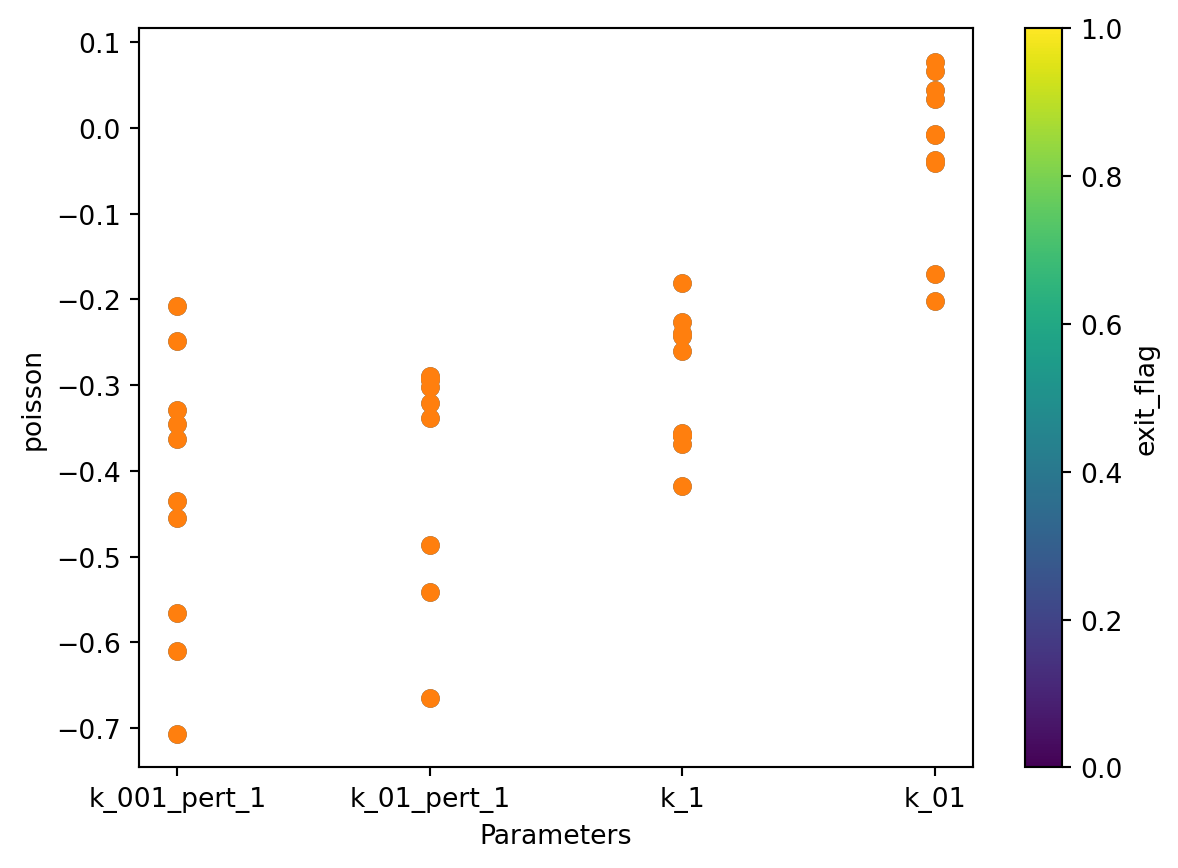

In [11]:
#| label: fig-kangle
#| fig-cap: Poisson ratio achieved vs target for different parameters
x_key = 'folder_name'
y_key = 'poisson'
color_key = 'exit_flag'
x_data = [data[x_key] for data in results if x_key in data]
y_data = [data[y_key] for data in results if y_key in data]
color_data = [data[color_key] for data in results if color_key in data]
plt.scatter(x_data, y_data, marker='o')
plt.scatter(x_data, y_data, marker='o')
#plt.ylim(-1, 0)  # Set y-axis limits
plt.xlabel('Parameters')  # X-axis label
plt.ylabel(y_key)  # Y-axis label # X-axis label
colorbar = plt.colorbar()  # Colorbar
colorbar.set_label(color_key)  # Colorbar label
plt.show()

::: {.notes}
In the end, k_angle does help control how much poisson ratio we are able to achieve, although it depends on other parameters as well. For example, putting $k_{angle} = 0.01$ when the perturbation is 2.0 makes most of the runs to fail prematurely and the poisson ratios achieved is not as low as $k_{angle} = 0.1$ in this case. But if I make the perturbation only 1.0, I achieve lower poisson ratios, but I also should run the $k_{angle} = 0.1$ case at perturbation 1.0. 

:::


In [12]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'sweep_poisson_k_01')
results = extract_data(folder_path)

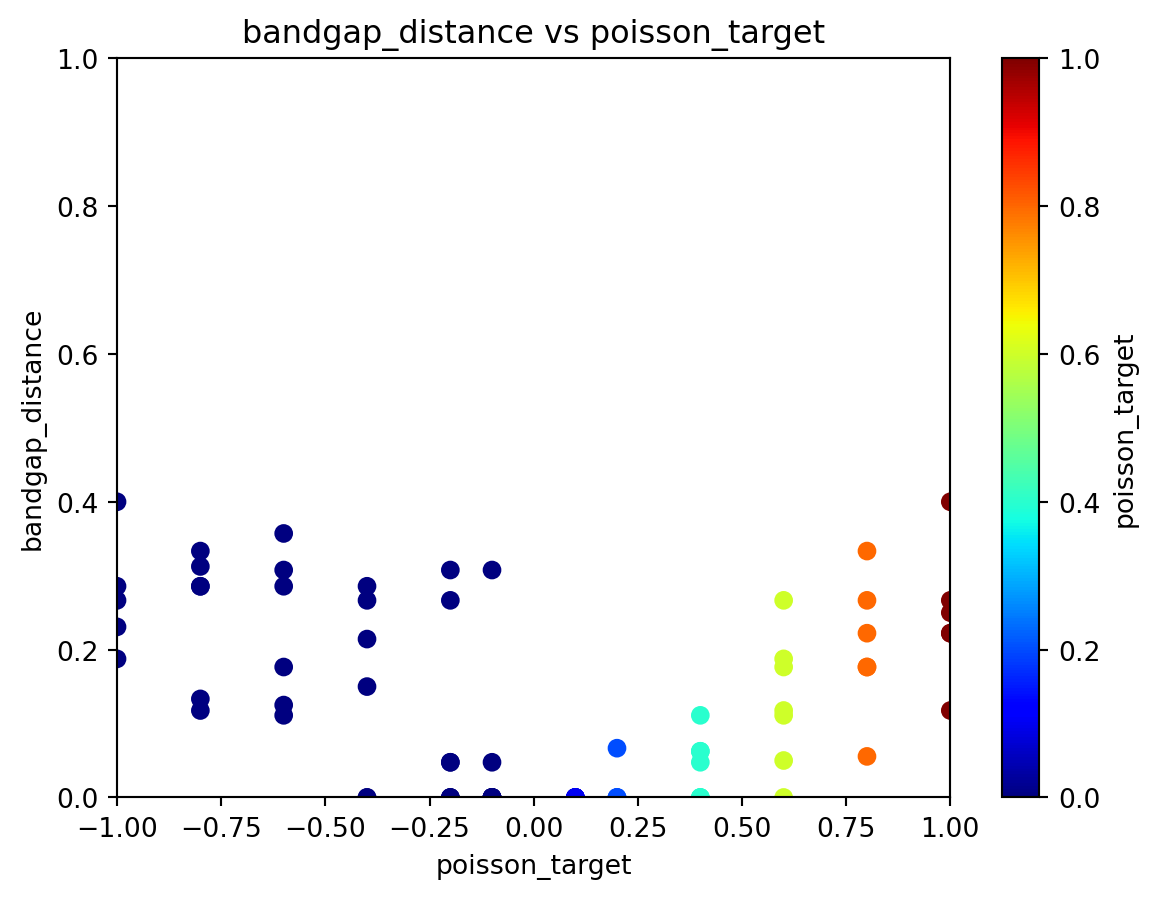

In [13]:
#| label: fig-poissonratios_k_01
#| fig-cap: Poisson ratio achieved vs target. Color bar represents bandgap difference.
plot_results(results, 'poisson_target',  'bandgap_distance', 'poisson_target')

In [14]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'large_network')
results = extract_data(folder_path)

In [15]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'large_network', 'acoustic')
results_acoustics = extract_data(folder_path)

In [16]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'shift_bandgap_open_to_close')
results = extract_data(folder_path)

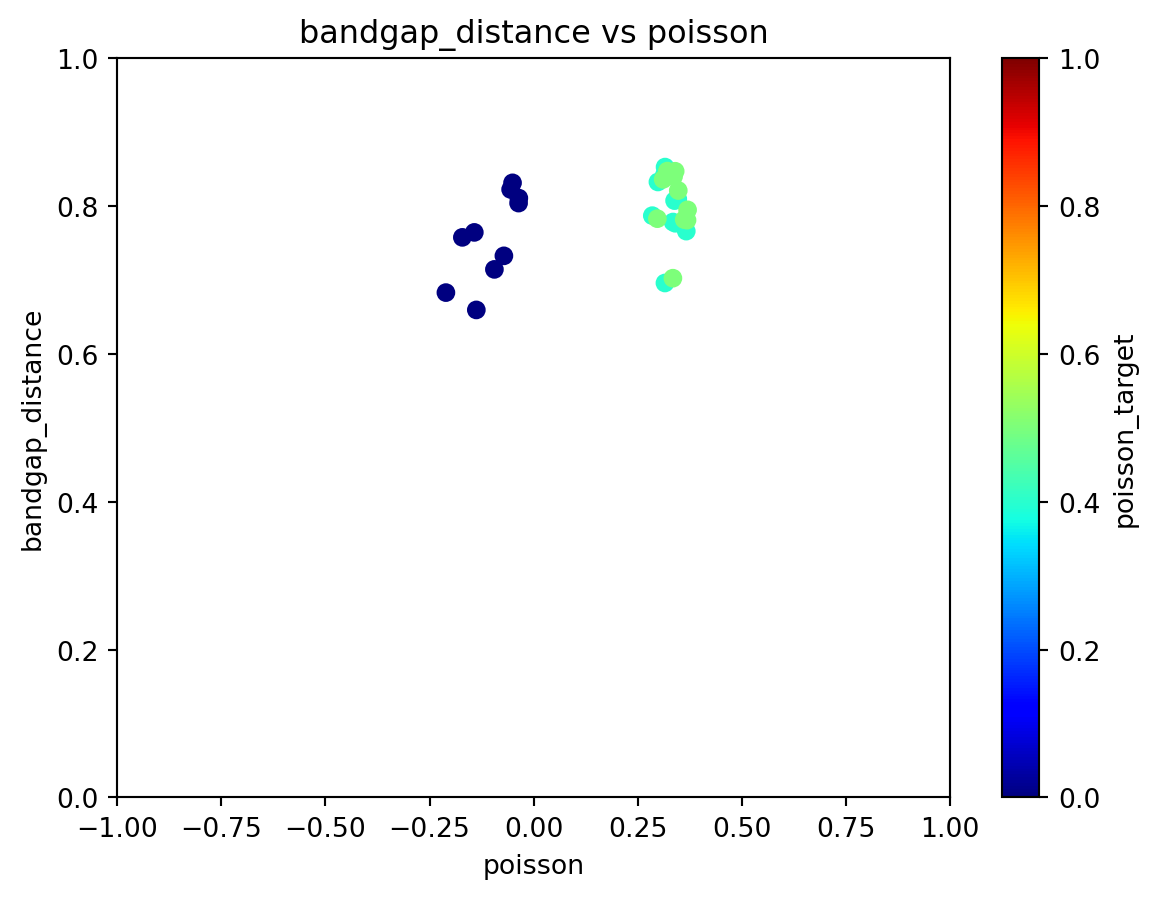

In [17]:
#| label: fig-poissonratios_k_01
#| fig-cap: Poisson ratio achieved vs target. Color bar represents bandgap difference.
plot_results(results, 'poisson',  'bandgap_distance', 'poisson_target')

In [18]:
# Set the folder_path to the 'runs/sweep_poisson' subdirectory from the current working directory
folder_path = os.path.join(os.getcwd(), 'runs', 'shift_bandgap_close_to_open')
results = extract_data(folder_path)

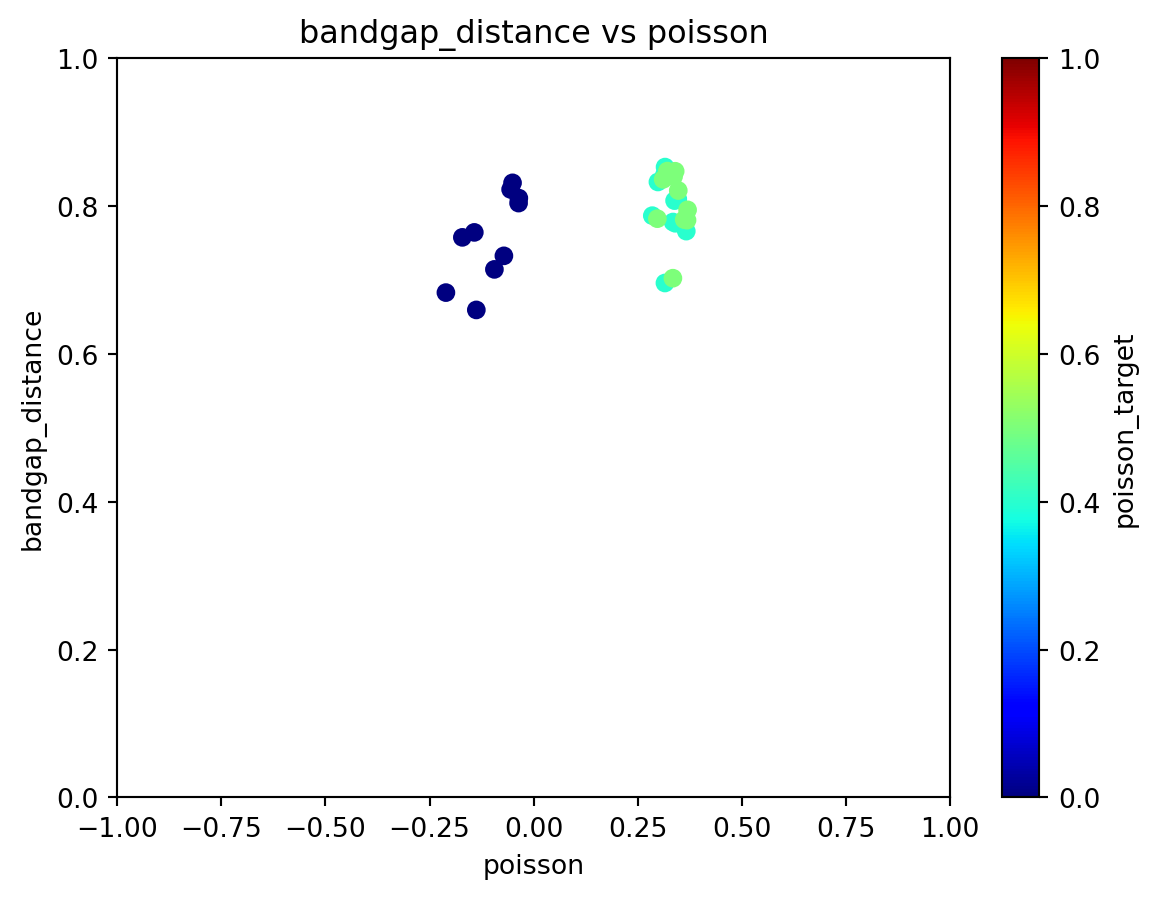

In [19]:
#| label: fig-poissonratios_k_01
#| fig-cap: Poisson ratio achieved vs target. Color bar represents bandgap difference.
plot_results(results, 'poisson',  'bandgap_distance', 'poisson_target')